In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [00:42<00:00, 171MB/s]
100% 4.16G/4.16G [00:42<00:00, 104MB/s]


In [ ]:
!unzip -qq /content/brats20-dataset-training-validation.zip

In [ ]:
import os
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
from skimage.transform import rotate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow as tf



In [ ]:
TRAIN_DATASET_PATH = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# renaming the file
try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")



File has been re-named successfully!


In [ ]:
# load .nii file as a numpy array
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [ ]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1854.603271484375


In [ ]:
# 자세한 과정은 chatGPT
scaler = MinMaxScaler()

test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [ ]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [ ]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

Slice Number: 95


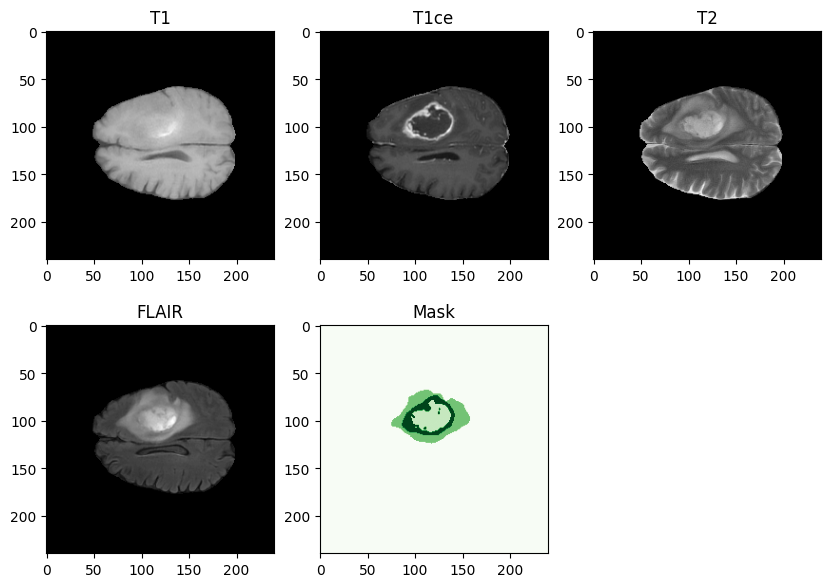

In [ ]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(10, 7))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice], cmap='Greens')
plt.title('Mask')
plt.show()

In [ ]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

# (width, height, slice)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


Slice number: 95


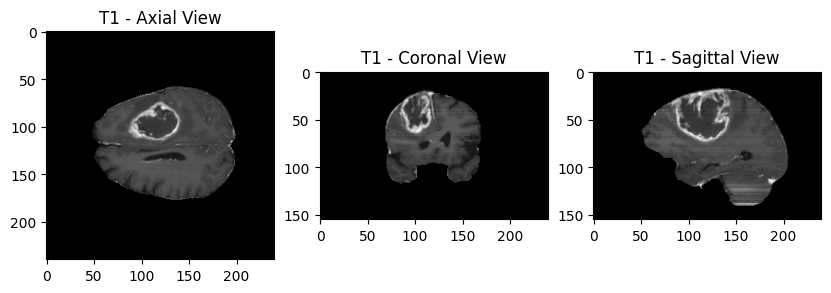

In [ ]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(10, 6))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Axial View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Coronal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

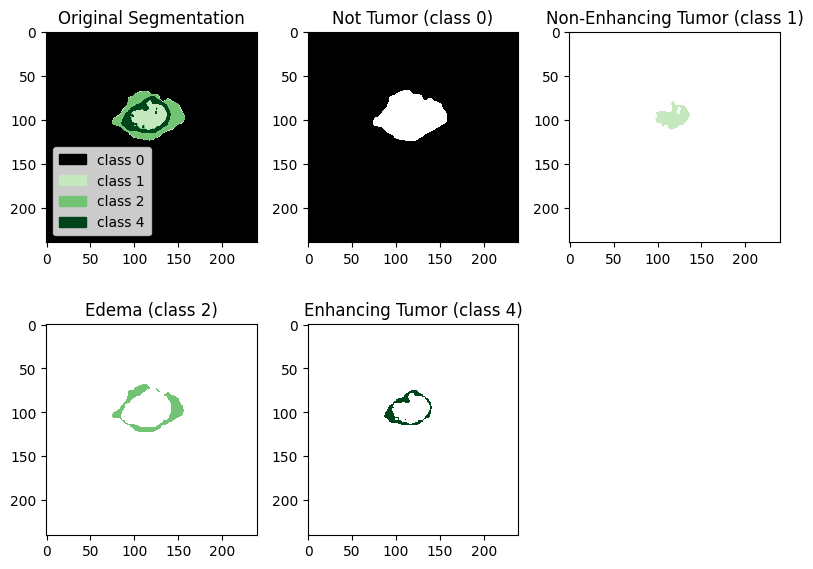

In [ ]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#000000', '#C6E8BF', '#73C375', '#00441B'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(2, 3, figsize=(8, 6))

ax[0, 0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0, 0].set_title('Original Segmentation')
ax[0, 0].legend(handles=legend, loc='lower left')

ax[0, 1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[0, 1].set_title('Not Tumor (class 0)')

ax[0, 2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[0, 2].set_title('Non-Enhancing Tumor (class 1)')

ax[1, 0].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[1, 0].set_title('Edema (class 2)')

ax[1, 1].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[1, 1].set_title('Enhancing Tumor (class 4)')

ax[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.1, random_state=123)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.07, random_state=123)



In [ ]:
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 308
Validation length: 37
Test length: 24


In [ ]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 96
VOLUME_START_AT = 25 # first slice of volume that we will include
IMG_SIZE=224

In [ ]:
# yolov4 처럼 batch_size는 없애야 할듯
# __data_generation 함수 없이 그냥 __getitem__에 바로 코딩

class UnetrDataset(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), n_channels = 2, shuffle=True):
        self.dim = dim
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        id = self.list_IDs[index]

        X = np.zeros((VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((VOLUME_SLICES, 240, 240))
        Y = np.zeros((VOLUME_SLICES, *self.dim, 4))

        case_path = os.path.join(TRAIN_DATASET_PATH, id)

        data_path = os.path.join(case_path, f'{id}_flair.nii');
        flair = nib.load(data_path).get_fdata()

        data_path = os.path.join(case_path, f'{id}_t1ce.nii');
        t1ce = nib.load(data_path).get_fdata()

        data_path = os.path.join(case_path, f'{id}_seg.nii');
        seg = nib.load(data_path).get_fdata()

        for j in range(VOLUME_SLICES):
          X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
          X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

          y[j] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        # mask: (VOLUME_SLICES, 240, 240, 4)
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));


        # X: (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2)
        # Y: (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4)
        return X/np.max(X), Y.numpy()


training_generator = UnetrDataset(train_ids)
valid_generator = UnetrDataset(val_ids)
test_generator = UnetrDataset(test_ids)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(96, 224, 224, 2)
(96, 224, 224, 4)
(96, 224, 224)
(96, 224, 224)
(96, 224, 224)
torch.Size([2, 224, 224, 96])


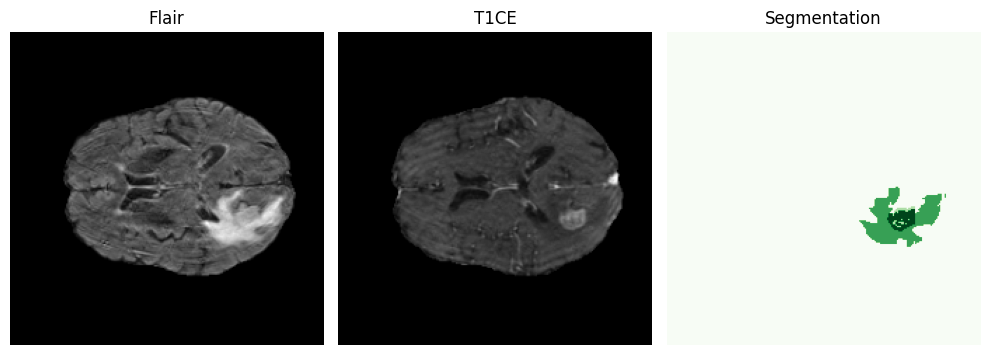

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader

# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation, cmap='Greens') # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[10]

print(type(X_batch))
print(type(Y_batch))

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]

print(X_batch.shape) # (100, 128, 128, 2)
print(Y_batch.shape) # (100, 128, 128, 4)

segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

print(flair_batch.shape) # (100, 128, 128)
print(t1ce_batch.shape) # (100, 128, 128)
print(segmentation_batch.shape) # (100, 128, 128)

print(torch.from_numpy(X_batch).permute(3, 1, 2, 0).shape)

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 50  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm


train_loader = DataLoader(
    dataset=training_generator,
    batch_size=1,
    shuffle=False,
    drop_last=False,
)

cnt = 0
loop = tqdm(train_loader, leave=True)

for batch_idx, (x, y) in enumerate(loop):

  print(x.shape)
  print(y.shape)
  cnt+=1
  if cnt == 1:
    break

# Y.numpy() 하니까 드디어 해결

  0%|          | 0/308 [00:01<?, ?it/s]

torch.Size([1, 96, 224, 224, 2])
torch.Size([1, 96, 224, 224, 4])


In [ ]:
train_loader = DataLoader(
    dataset=training_generator,
    batch_size=1,
    shuffle=False,
    drop_last=False,
)
x, y = next(iter(train_loader))

print(x.shape)
print(y.shape)

torch.Size([1, 96, 224, 224, 2])
torch.Size([1, 96, 224, 224, 4])


In [ ]:
x = x.permute(0, 4, 2, 3, 1).float()
print(x.shape)

torch.Size([1, 2, 224, 224, 96])


In [ ]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from torch import Tensor

class Embeddings(nn.Module):
    def __init__(self, input_shape, patch_size=16, embed_dim=768, dropout=0.):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = input_shape[-4]
        self.n_patches = int((input_shape[-1] * input_shape[-2] * input_shape[-3]) / (patch_size * patch_size * patch_size))
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=self.in_channels, out_channels=self.embed_dim,
                                          kernel_size=self.patch_size, stride=self.patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, self.embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = rearrange(x, "b n h w d -> b (h w d) n")
        # batch, embed_dim, height/patch, width/patch, depth/patch
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


In [ ]:
E = Embeddings(x.shape[1:]) # -> torch.Size([2, 1176, 768])
summary(E, x.shape[1:], device='cpu')

embedding_x = E(x)
print(embedding_x.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 768, 14, 14, 6]       6,292,224
           Dropout-2            [-1, 1176, 768]               0
Total params: 6,292,224
Trainable params: 6,292,224
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 36.75
Forward/backward pass size (MB): 13.78
Params size (MB): 24.00
Estimated Total Size (MB): 74.53
----------------------------------------------------------------
torch.Size([1, 1176, 768])


In [ ]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self, d_model: int = 768, n_head: int = 8, dropout: float = 0.1):
    super().__init__()
    self.d_model = d_model
    self.n_head = n_head
    assert d_model % n_head == 0, "d_model is not divisible by n_head"
    self.d_k = d_model // n_head

    self.query = nn.Linear(d_model, d_model, bias=False)
    self.key = nn.Linear(d_model, d_model, bias=False)
    self.value = nn.Linear(d_model, d_model, bias=False)

    self.scale = math.sqrt(self.d_k)

    self.dense = nn.Linear(d_model, d_model, bias=False)
    self.dropout = nn.Dropout(dropout)

  def scaled_dot_product_attention(self, query, key, value, mask):
    # (Seq_len, d_k) -> (Seq_len, Seq_len)

    matmul_qk = query @ key.transpose(-2, -1)

    scaled_attention_logits = matmul_qk / self.scale

    if mask is not None:
      scaled_attention_logits.masked_fill_(mask == 0, -1e9) # if mask == 0 fill it as -1e9 (sim -inf)

    attention_score = scaled_attention_logits.softmax(dim=-1)
    attention_weights = self.dropout(attention_score)
    x = attention_weights @ value

    return x, attention_score

  def split_heads(self, x, n_head, d_k):
    # (Batch, Seq_len, d_model) -> (Batch, Seq_len, n_head, d_k) -> (Batch, n_head, Seq_len, d_k)
    x = x.view(x.shape[0], x.shape[1], n_head, d_k).transpose(1, 2)
    return x

  def forward(self, query, key, value, mask):
    Q = self.query(query) # (Seq_len, d_model) -> (Seq_len, d_model)
    K = self.key(key) # (Seq_len, d_model) -> (Seq_len, d_model)
    V = self.value(value) # (Seq_len, d_model) -> (Seq_len, d_model)

    Q = self.split_heads(Q, self.n_head, self.d_k)
    K = self.split_heads(K, self.n_head, self.d_k)
    V = self.split_heads(V, self.n_head, self.d_k)

    x, attention_score = self.scaled_dot_product_attention(Q, K, V, mask)

    # (Batch, n_head, Seq_len, d_k) -> (Batch, Seq_len, n_head, d_k) -> (Batch, Seq_len, d_model)
    concat_attention  = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.n_head * self.d_k)

    # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_model)
    return self.dense(concat_attention), attention_score

In [ ]:
mha = MultiHeadAttentionBlock()

mha_x = mha(embedding_x, embedding_x, embedding_x, None)

mha_x[0].shape

torch.Size([1, 1176, 768])

In [ ]:
class FeedForwardBlock(nn.Module):
  def __init__(self, d_model: int = 768, dropout: float = 0.1):
    super().__init__()
    self.ff_1 = nn.Linear(d_model, d_model * 4) # w1 and b1
    self.relu = nn.GELU()
    self.dropout = nn.Dropout(dropout)
    self.ff_2 = nn.Linear(d_model * 4, d_model) # w2 and b2

  def forward(self, x):
    x = self.ff_2(self.dropout(self.relu(self.ff_1(x))))
    return x


In [ ]:
FF = FeedForwardBlock()
summary(FF, mha_x[0].shape[1:], device='cpu')

ff_x = FF(mha_x[0])
print(ff_x.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 1176, 3072]       2,362,368
              GELU-2           [-1, 1176, 3072]               0
           Dropout-3           [-1, 1176, 3072]               0
            Linear-4            [-1, 1176, 768]       2,360,064
Total params: 4,722,432
Trainable params: 4,722,432
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.45
Forward/backward pass size (MB): 89.58
Params size (MB): 18.01
Estimated Total Size (MB): 111.04
----------------------------------------------------------------
torch.Size([1, 1176, 768])


In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, d_model: int = 768, n_head: int = 8, dropout: float = 0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(d_model)
    self.self_attention = MultiHeadAttentionBlock(d_model, n_head, dropout)
    self.feed_forward = FeedForwardBlock(d_model, dropout)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    res = x
    x = self.layer_norm(x)
    x, attention_score = self.self_attention(x, x, x, None)
    x = res + self.dropout(x)

    res = x
    x = self.layer_norm(x)
    x = self.feed_forward(x)
    x = res + self.dropout(x)

    return x


class VisionTransformer(nn.Module):
  def __init__(self, d_model: int = 768, n_head: int = 8, depth: int = 12, dropout: float = 0.1, extract: list = [3,6,9,12]):
    super().__init__()

    self.ViT = nn.ModuleList([EncoderBlock(d_model, n_head, dropout) for _ in range(depth)])
    self.extract = extract

  def forward(self, x):
    Z_layer = []

    for i, layer in enumerate(self.ViT):
      x = layer(x)
      if i+1 in self.extract:
        Z_layer.append(x)

    return Z_layer





In [109]:
ViT = VisionTransformer()
#summary(ViT, embedding_x.shape[1:], device='cpu')

for i in ViT(embedding_x):
  print(i.shape)

torch.Size([1, 1176, 768])
torch.Size([1, 1176, 768])
torch.Size([1, 1176, 768])
torch.Size([1, 1176, 768])


In [110]:
class Upsample3DBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    self.upsample = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

  def forward(self, x):
    return self.upsample(x)

class Conv3dBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, act=True):
    super().__init__()
    self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, stride=1, padding=((kernel_size - 1) // 2))
    self.act = act
    self.batch_norm = nn.BatchNorm3d(out_channels)
    self.relu = nn.ReLU(True)

  def forward(self, x):
    if self.act:
      return self.relu(self.batch_norm(self.conv3d(x)))
    else:
      return self.conv3d(x)

class Deconv3dBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.deconv3d = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv3d = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=((kernel_size - 1) // 2))
    self.batch_norm = nn.BatchNorm3d(out_channels)
    self.relu = nn.ReLU(True)

  def forward(self, x):
    return self.relu(self.batch_norm(self.conv3d(self.deconv3d(x))))



In [ ]:
class UNETR(nn.Module):
  def __init__(self, img_shape=(224, 224, 96), patch_size=16, in_channels=2,
               out_channels=4, d_model=768, n_head=8, dropout=0.1):
    super().__init__()

    self.img_shape = img_shape
    self.patch_size = patch_size
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.d_model = d_model
    self.n_head = n_head
    self.dropout = dropout
    self.patch_dim = [int(x / patch_size) for x in img_shape]

    self.embedding = Embeddings((in_channels, *img_shape))

    # U-net encoder
    self.encoder = VisionTransformer()

    # U-net decoder
    self.decoder0 = nn.Sequential(
        Conv3dBlock(in_channels, 32, 3),
        Conv3dBlock(32, 64, 3)
    )

    self.decoder3 = nn.Sequential(
        Deconv3dBlock(d_model, 128, 3),
        Deconv3dBlock(128, 128, 3),
        Deconv3dBlock(128, 128, 3)
    )

    self.decoder6 = nn.Sequential(
        Deconv3dBlock(d_model, 256, 3),
        Deconv3dBlock(256, 256, 3)
    )

    self.decoder9 = nn.Sequential(
        Deconv3dBlock(d_model, 512, 3)
    )

    self.decoder12_upsampler = Upsample3DBlock(d_model, 512)

    self.decoder9_upsampler = nn.Sequential(
        Conv3dBlock(1024, 256, 3),
        Conv3dBlock(256, 256, 3),
        Conv3dBlock(256, 256, 3),
        Upsample3DBlock(256, 256)
    )

    self.decoer6_upsampler = nn.Sequential(
        Conv3dBlock(512, 128, 3),
        Conv3dBlock(128, 128, 3),
        Upsample3DBlock(128, 128)
    )

    self.decoder3_upsampler = nn.Sequential(
        Conv3dBlock(256, 64, 3),
        Conv3dBlock(64, 64, 3),
        Upsample3DBlock(64, 64)
    )

    self.decoder0_header = nn.Sequential(
        Conv3dBlock(128, 64, 3),
        Conv3dBlock(64, 64, 3),
        Conv3dBlock(64, out_channels, 1, act=False)
    )

    def forward



